# Introduction

In this notebook, I present two models of mobility flow forecasting alghorithms.

The dataset that has been used is taken from a mobility flow dataset provided by Regione Emilia-Romagna for research purposes to the Complex System Group - City Science Lab of the University of Bologna structured as follows:

| DateTime  | Road 1 | Road 2 | ... | Road N |
| ----------- | ----------- | | ----------- | ----------- |   
| 2020-02-01 00:00:00+00:00      | # vehicles       | | ... # vehicles ...      | | ...|  
| 2020-02-01 00:15:00+00:00      | # vehicles       | | ... # vehicles ...      | | ...| 
|...| | ... | ... | |

Hence, in this fifteen-minutes-sampled-timeseries database, it is shown the amount of vehicles that drives on a specific road. The goal of the present notebook is to predict these numbers at best for each road.

The first implementation is a Multilayer Perceptron Model (ANN) composed by 3 + 1 levels, while the second alghorithm that has been applied to get predictions is Prophet, an open source software released by Facebook's Code Data Science Team. Both results have been compared to the observed data distribution and I have find out that the first implementation gets better results probably due to the fact that Prophet works best with time series that have strong seasonal effects and several seasons of historical data, while for this notebook a month of data has been used. 

# Initializations

## Import libraries

In [5]:
import os
import glob
import keras
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
%matplotlib inline

## Install useful packages

In [6]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 135 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.0 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6638267 sha256=35252c51bca7fc15a5cb6c79c87be674221b9e7ebabc637ee90c35ea06212ee5
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.4
    Uninstalling cmdstanpy-1.0.4:
      Successfully uninstalled cmdstanpy-1.0.4
ERROR: pip's dependency resolver does not currently take into account all the 

## Libraries for forcasting

In [7]:
import fbprophet as Prophet
import time

## Plot Tools

Here I define a python class that simplifies the visualization of results by setting a statistical threshold.

In [8]:
class cg():
  LOW  = 1
  AVE  = 2
  HIGH = 3

kpi_thresh = {
  cg.LOW  : 0.20,
  cg.AVE  : 0,
  cg.HIGH : 0.80
}

kpi_colors = {
  cg.LOW  : 'blue',
  cg.AVE  : 'white',
  cg.HIGH : 'red'
}

# Prepare DataSet

## Read Dataset 

Importing the whole dataset from Google Drive and unzipping it into a data folder.

In [9]:
from google.colab import drive
drive.mount('/gdrive')

zip_file = zipfile.ZipFile("/gdrive/MyDrive/Colab_Notebooks/dataset.zip", 'r')
zip_file.extractall()
zip_file.close()

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


Reading all the .csv files in the unzipped folder and creating a unique dataframe indexed by times.

Here, in the columns there are the roads that label the street network and the column values are the quarter hour's counter.  

In [10]:
path = f'dataset/'
all_files = glob.glob(os.path.join(path , "*.csv"))
li = []

for filename in all_files:
  df = pd.read_csv(filename, sep=";", index_col=0, header=0, parse_dates=True).tz_convert("Europe/Rome").tz_localize(None)
  li.append(df)

frame = pd.concat(li, axis=0, ignore_index=False)
frame = frame.T.groupby([s.split('_')[0] for s in frame.T.index.values]).sum().T.sort_index()
frame = frame[['174']] # I pick up one road on which focusing the analysis.
frame = frame.rename(columns={x:f'road_{y}' for x,y in zip(frame.columns,range(0,len(frame.columns)))})

## Dataset for Multilayer Perceptron

Here I select a subset of the data in order to avoid significant discontinuities in the timeseries. Moreover, I picked up one road on which focusing the analysis.

In [11]:
start_date = pd.to_datetime('2021-09-30 00:00:00')
stop_date = pd.to_datetime('2021-10-31 23:59:59')
mask_multiperceptron = (frame.index >= start_date) & (frame.index <= stop_date)
df_mp = frame.loc[mask_multiperceptron]
df_mp = df_mp.iloc[:, 0:1]

                     road_0
datetime                   
2021-10-01 00:00:00   127.0
2021-10-01 00:15:00   112.0
2021-10-01 00:30:00    66.0
2021-10-01 00:45:00    49.0
2021-10-01 01:00:00    61.0
...                     ...
2021-10-31 22:45:00   134.0
2021-10-31 23:00:00   149.0
2021-10-31 23:15:00   124.0
2021-10-31 23:30:00   116.0
2021-10-31 23:45:00   144.0

[2976 rows x 1 columns]


Dataset visualization
- On the x-axis the datetime is shown;
- On the y-axis the number of vehicles that crossed that road in 15 minutes. 

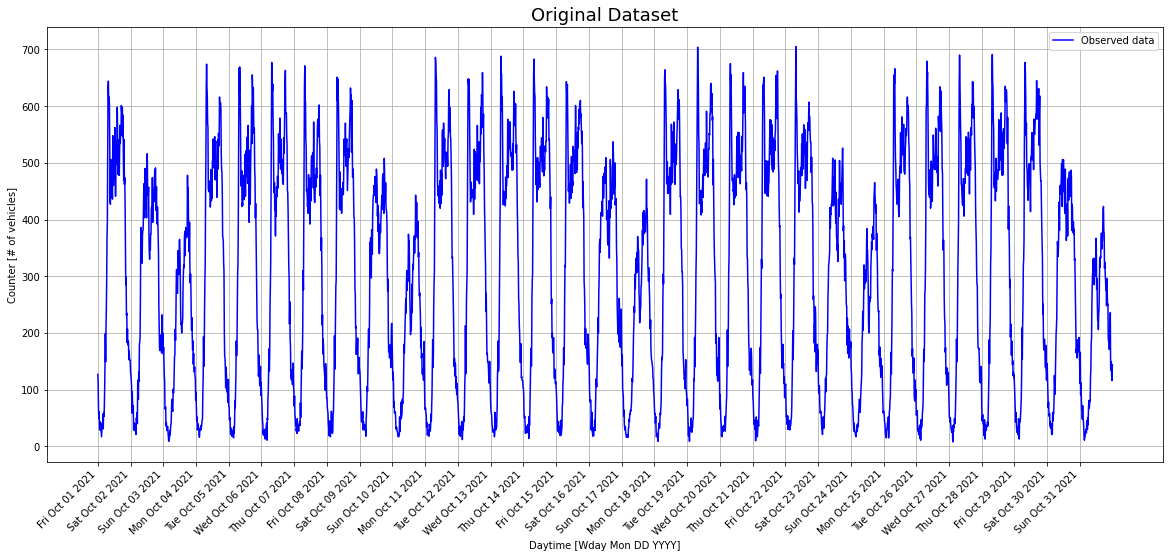

In [12]:
ts = [ t.timestamp() for t in df_mp.index ]
ts_lbl = [ t.strftime('%a %b %d %Y') for t in df_mp.index ]
tick_us = 96

fig, ax = plt.subplots(1,1, figsize=(20,8), sharex=True)
ax.set_xlabel('Daytime [Wday Mon DD YYYY]')
ax.set_ylabel('Counter [# of vehicles]')
ax.set_title(f'Original Dataset', size=18)
ax.plot(ts, df_mp, c='blue', label='Observed data')
ax.set_xticks(ts[::tick_us])
ax.set_xticklabels(ts_lbl[::tick_us], rotation=45, ha='right')
ax.grid(which='major', linestyle='-')
ax.grid(which='minor', linestyle='--')
ax.legend()

plt.show()

## Dataset for Prophet

Using Prophet, I split the whole dataset into two classes: the first one is the training-dataset and the second one is the test-dataset. Moreover, Prophet requires specific names for the dataframe columns: the datatime column must be labelled as "*ds*" while the counter column as "*y*".

In [13]:
df_tf = frame.iloc[:, 0:1]
start_date_train = pd.to_datetime('2021-09-30 00:00:00')
stop_date_train = pd.to_datetime('2021-10-27 23:59:59')
stop_date_test = pd.to_datetime('2021-10-31 23:59:59')
mask_period = (df_tf.index >= start_date_train) & (df_tf.index <= stop_date_test)
mask_train = (df_tf.index >= start_date_train) & (df_tf.index <= stop_date_train)
mask_test = (df_tf.index > stop_date_train) & (df_tf.index <= stop_date_test)

df_train = df_tf.loc[mask_train].reset_index(level=0)
df_test = df_tf.loc[mask_test].reset_index(level=0)

df_train = df_train.rename(columns = {df_train.columns[0]:'ds', df_train.columns[1]:'y'})
df_test = df_test.rename(columns = {df_test.columns[0]:'ds', df_test.columns[1]:'y'})

In this block and in the following I show the data population used for the train and for the test of the alghoritm.

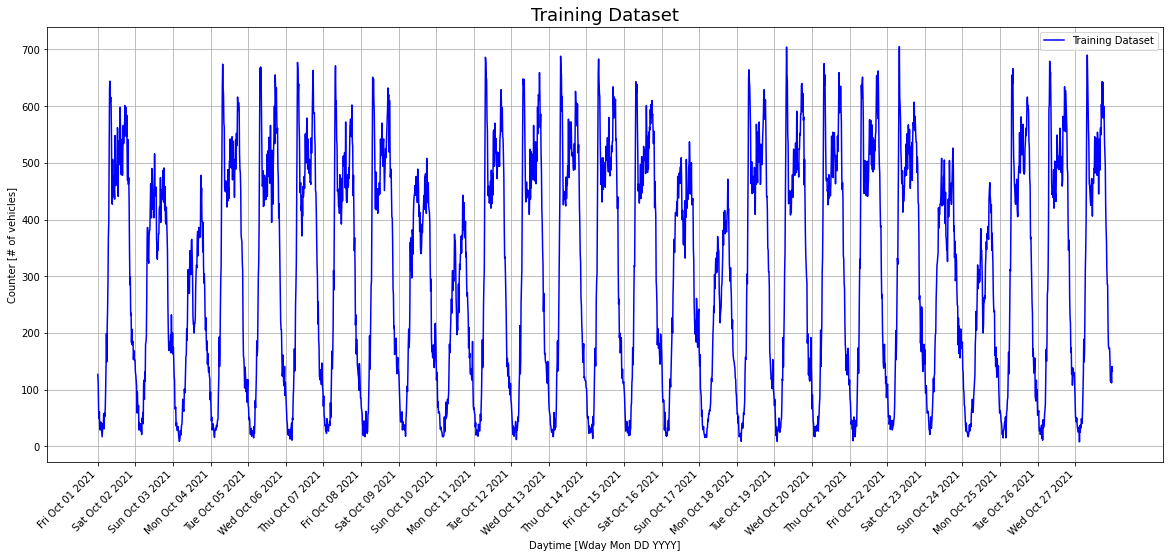

In [14]:
# Data Train Visualization
ts3 = [ t.timestamp() for t in pd.to_datetime(df_train.ds) ]
ts_lbl3 = [ t.strftime('%a %b %d %Y') for t in pd.to_datetime(df_train.ds) ]
tick_us3 = 96

fig, ax3 = plt.subplots(1,1, figsize=(20,8))
ax3.set_xlabel('Daytime [Wday Mon DD YYYY]')
ax3.set_ylabel('Counter [# of vehicles]')
ax3.set_title(f'Training Dataset', size=18)
ax3.plot(ts3, df_train['y'], c='blue', label='Training Dataset')
ax3.set_xticks(ts3[::tick_us3])
ax3.set_xticklabels(ts_lbl3[::tick_us3], rotation=45, ha='right')
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle='--')
ax3.legend()

plt.show()

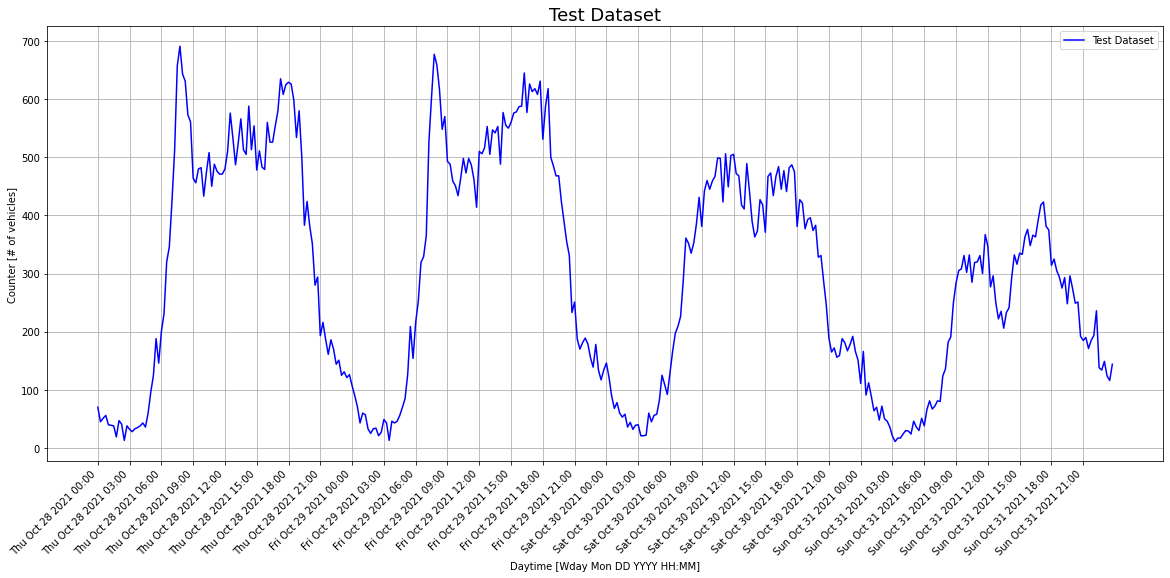

In [15]:
# Data Test Visualization
ts2 = [ t.timestamp() for t in pd.to_datetime(df_test.ds) ]
ts_lbl2 = [ t.strftime('%a %b %d %Y %H:%M') for t in pd.to_datetime(df_test.ds) ]
tick_us2 = 12

fig, ax2 = plt.subplots(1,1, figsize=(20,8), sharey=True)
ax2.set_xlabel('Daytime [Wday Mon DD YYYY HH:MM]')
ax2.set_ylabel('Counter [# of vehicles]')
ax2.set_title(f'Test Dataset', size=18)
ax2.plot(ts2, df_test['y'], c='blue', label='Test Dataset')
ax2.set_xticks(ts2[::tick_us2])
ax2.set_xticklabels(ts_lbl2[::tick_us2], rotation=45, ha='right')
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle='--')
ax2.legend()

plt.show()

# Multilayer Perceptron

## Reshape Dataset and Features Scaling

Here I reshape the dataset by adding a windows size of 96 (number of quarters of an hour in a day) by rescaling it with scikit-learn function MinMaxScaler to simplify the computation step.

In [16]:
def create_dataset(dataset, window=1):
    dataX, dataY= [], []
    for i in range(len(dataset)-window-1):
        a = dataset[i:(i+window),0]
        dataX.append(a)
        dataY.append(dataset[i+window,0])
    return np.array(dataX), np.array(dataY)

scaler = MinMaxScaler(feature_range=(0,1))
df_mp = scaler.fit_transform(np.array(df_mp).reshape(-1,1))

## Split Train and Test

I will use the 80% of data to train the model and the remaining 20% to test it.

In [17]:
training_size = int(len(df_mp)*0.80)
test_size = len(df_mp)-training_size
train_data, test_data = df_mp[0:training_size,:], df_mp[training_size:len(df_mp),:1]

window = 96
X_train,y_train = create_dataset(train_data,window)
X_test, y_test = create_dataset(test_data,window)

## Optimization Method and Model Training

Here I define the ANN's architecture: in order to train the model I implement a 3 + 1 layers each with a rectified linear unit as activation function.

In [18]:
model = Sequential()
model.add(Dense(40, input_dim=window, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(1))

Choosing the optimizer function from Keras' package of Tensorflow. Here I decided to use the adaptive gradient algorithm which is adapted relative to how frequently a parameter gets updated during training.

In [19]:
opt  = tf.keras.optimizers.Adagrad(learning_rate = 0.05)
model.compile(optimizer=opt ,loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                3880      
                                                                 
 dense_1 (Dense)             (None, 50)                2050      
                                                                 
 dense_2 (Dense)             (None, 40)                2040      
                                                                 
 dense_3 (Dense)             (None, 1)                 41        
                                                                 
Total params: 8,011
Trainable params: 8,011
Non-trainable params: 0
_________________________________________________________________


Training of the model to minimize the loss function. 

In [20]:
model.fit(X_train, y_train, epochs=300, batch_size=10, verbose=1)

Epoch 1/300
229/229 [==============================] - 3s 6ms/step - loss: 0.0176
Epoch 2/300
229/229 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 3/300
229/229 [==============================] - 1s 6ms/step - loss: 0.0036
Epoch 4/300
229/229 [==============================] - 1s 3ms/step - loss: 0.0030
Epoch 5/300
229/229 [==============================] - 1s 4ms/step - loss: 0.0026
Epoch 6/300
229/229 [==============================] - 1s 5ms/step - loss: 0.0025
Epoch 7/300
229/229 [==============================] - 1s 6ms/step - loss: 0.0024
Epoch 8/300
229/229 [==============================] - 1s 5ms/step - loss: 0.0023
Epoch 9/300
229/229 [==============================] - 1s 5ms/step - loss: 0.0022
Epoch 10/300
229/229 [==============================] - 1s 5ms/step - loss: 0.0022
Epoch 11/300
229/229 [==============================] - 1s 4ms/step - loss: 0.0021
Epoch 12/300
229/229 [==============================] - 1s 5ms/step - loss: 0.0020
Epoch 13/300


## Prediction

Getting the prediction.

In [21]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [22]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [23]:
train_predict = train_predict.astype(int)
test_predict = test_predict.astype(int)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

## Accuracy Measures

Computing the accuracy measures of both training and test data.
Here we can see that the R-squared scores of 98% test of accuracy

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
print('** Train Accuracy **')
print('RMSE-train:',np.sqrt(mean_squared_error(y_train,train_predict)))
print('MAE-train:',mean_absolute_error(y_train,train_predict))
print('R_2-train:',r2_score(y_train,train_predict))
print('\n** Test Accuracy **')
print('RMSE-test:',np.sqrt(mean_squared_error(y_test,test_predict)))
print('MAE-test:',mean_absolute_error(y_test,test_predict))
print('R_2-test:',r2_score(y_test,test_predict))

** Train Accuracy **
RMSE-train: 21.370570190297492
MAE-train: 16.247481384143672
R_2-train: 0.9884691237299682

** Test Accuracy **
RMSE-test: 26.646614872593794
MAE-test: 20.21442885771543
R_2-test: 0.981692189448575


## Plot
###Observed Dataset - Training Set - Test Set

Here I present a visualization of the three sets of data. 
- The original dataset, the one that has been observed, is marked in blue; 
- The dataset that has been used for the training part of the alghoritm is marked in red; 
- Finally, the test dataset is labelled in black and it can be said that the agreement with the observed data is remarkable.

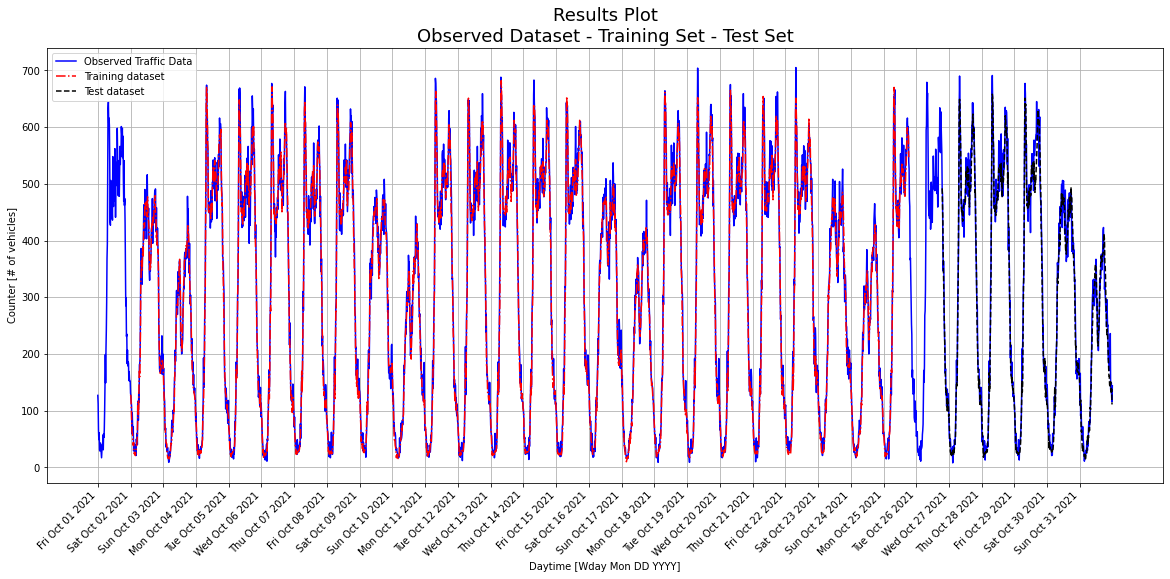

In [25]:
trainPredictPlot = np.empty_like(df_mp)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window:len(train_predict)+window, :] = train_predict

testPredictPlot = np.empty_like(df_mp)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(window*2)+1:len(df_mp)-1, :] = test_predict

fig, ax = plt.subplots(1,1, figsize=(20,8))
ax.set_xlabel('Daytime [Wday Mon DD YYYY]')
ax.set_ylabel('Counter [# of vehicles]')
ax.set_title(f'Results Plot\nObserved Dataset - Training Set - Test Set', size=18)
ax.plot(ts, scaler.inverse_transform(df_mp),'-', c='blue', label='Observed Traffic Data')
ax.plot(ts, trainPredictPlot,'-.', c='red', label='Training dataset')
ax.plot(ts, testPredictPlot,'--', c= 'black', label='Test dataset')
ax.set_xticks(ts[::tick_us])
ax.set_xticklabels(ts_lbl[::tick_us], rotation=45, ha='right')
ax.grid(which='major', linestyle='-')
ax.grid(which='minor', linestyle='--')
ax.legend()
plt.show()

## Prepare Data Comparison

In this section I focus on the period used for the test analysis and I show a comparison between the data observed and the predicted data by the multilayer perceptron. 

Firstly, I compute the difference between the original data and the forecasted data, then the quantile has been computed assuming two levels of thresholds as defined in the class cg().

In [26]:
datetime = pd.to_datetime([int(t) for t in ts], unit='s')

df2 = pd.DataFrame(index=datetime, columns=['test_predict_plot', 'original_data'])
df2['test_predict_plot'] = testPredictPlot
df2['original_data'] = scaler.inverse_transform(df_mp)
mask_compare = (df2.index > stop_date_train) & (df2.index <= stop_date_test)
df2 = df2.loc[mask_compare]
dif = df2.test_predict_plot - df2.original_data

ave = dif.mean()
std = dif.std()
thresh_up = dif.quantile(kpi_thresh[cg.HIGH])
thresh_down = dif.quantile(kpi_thresh[cg.LOW])
df2['loc_diff'] = dif
df2['loc_kpi'] = cg.LOW
df2.loc[ df2.loc_diff > thresh_down, 'l_kpi'] = cg.AVE
df2.loc[ df2.loc_diff > thresh_up, 'l_kpi'] = cg.HIGH

##Plot - Difference Results

Here I graphically present the results of the comparison.

In the first plot, the observed traffic data is shown in blue colour while the forcasted data using the perceptron alghoritm are shown in red; in this panel one can observe that the two series follow a similar trend, hence the prediction is very accurate. 

The differences between these two values are shown in the second panel: the majority of points can be found in the area between the 20th and the 80th percentile bands.

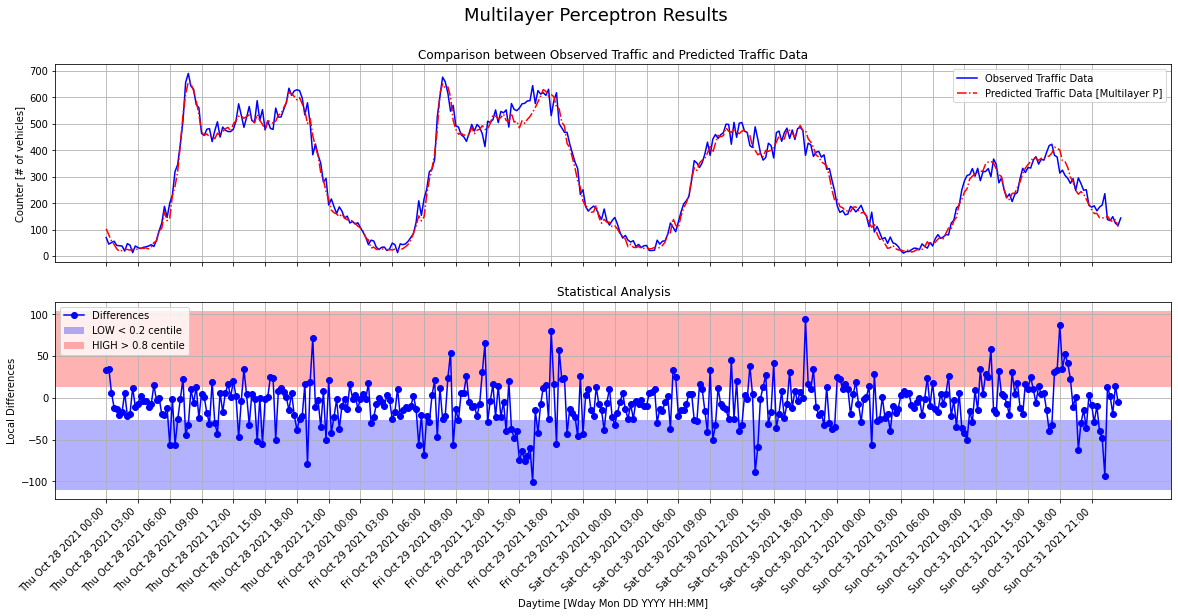

In [27]:
ts3 = [ t.timestamp() for t in df2.index ]
ts_lbl3 = [ t.strftime('%a %b %d %Y %H:%M') for t in df2.index ]
tick_us3 = 12
fig, axs = plt.subplots(2,1, figsize=(20,8), sharex=True)
ax3 = axs[0]
ax3.set_title(f'Comparison between Observed Traffic and Predicted Traffic Data')
ax3.plot(ts3, df2.original_data,'-', c='blue', label='Observed Traffic Data')
ax3.plot(ts3, df2.test_predict_plot,'-.', c='red', label='Predicted Traffic Data [Multilayer P]')
ax3.set_ylabel('Counter [# of vehicles]')
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle='--')
ax3.legend()

ax3 = axs[1]
ax3.set_title(f'Statistical Analysis')
ax3.set_xticks(ts3[::tick_us3])
ax3.set_xticklabels(ts_lbl3[::tick_us3], rotation=45, ha='right')
ax3.plot(ts3, df2['loc_diff'],'-o', c='blue', label='Differences')
ax3.axhspan(ax3.get_ylim()[0], thresh_down, facecolor=kpi_colors[cg.LOW] , alpha=0.3, label=f'LOW < {kpi_thresh[cg.LOW]} centile')
ax3.axhspan(thresh_down, thresh_up, facecolor=kpi_colors[cg.AVE] , alpha=0.3)
ax3.axhspan(thresh_up, ax3.get_ylim()[1], facecolor=kpi_colors[cg.HIGH] , alpha=0.3, label=f'HIGH > {kpi_thresh[cg.HIGH]} centile')

ax3.grid()
ax3.legend()
ax3.set_xlabel(f'Daytime [Wday Mon DD YYYY HH:MM]')
ax3.set_ylabel('Local Differences')
plt.suptitle(f'Multilayer Perceptron Results', size=18 )
plt.show()

# Prophet

In this section, a different forecast alghoritm is applied to the time-series data. 

I am using a procedure implemented by Facebook's team known as Prophet (https://facebook.github.io/prophet/). Facebook Prophet is an open-source algorithm for generating time-series models that is essentially based over the sum of three functions of time plus an error term: growth $g(t)$, seasonality $s(t)$, holidays $h(t)$ , and error $e_t$:
> $y(t) = g(t) + s(t) + h(t) + e_t$



## Prediction

Usually, time series have abrupt changes in their trajectories and Prophet, in the growth function. Prophet will automatically detect these so called *changepoints* and will allow the trend to adapt appropriately.

In [28]:
t_2 = time.time()
m = Prophet.Prophet(changepoint_prior_scale=0.01, yearly_seasonality=False)

test_time = df_test.iloc[:,0:1]
forecast = m.fit(df_train).predict(test_time)
t_3 = time.time()

delta_t = t_3-t_2

## Plot

From the following plots we can state that the model has a good agreement with the trend and the seasonal componets of the observed data.

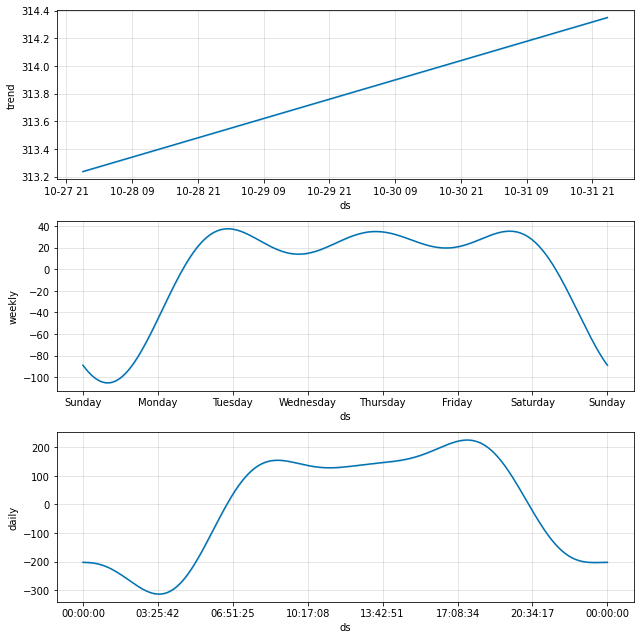

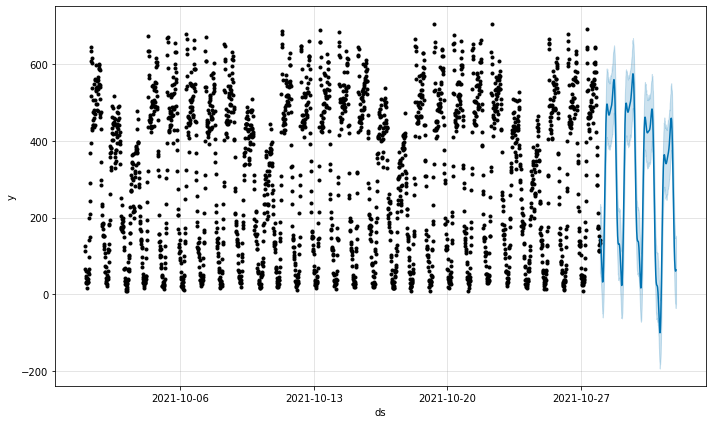

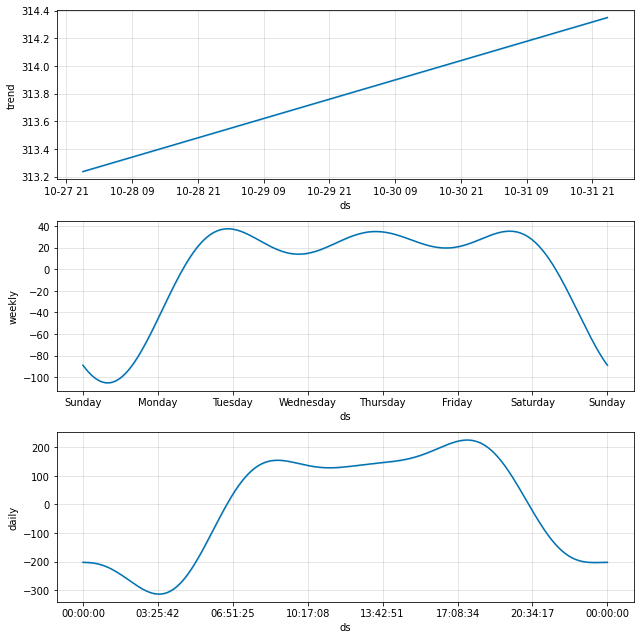

In [29]:
m.plot(forecast)
m.plot_components(forecast)

## Accuracy Measures

Even if the root mean squared error between the original population of data and the forcasted one is very high, the R squared scored indicates a good correlation between the two sets.

In [30]:
rmse = np.sqrt(mean_squared_error(df_test['y'], forecast['yhat'].astype(int)))
print(f'Root Mean Squared Error :{rmse}')
r_sq = r2_score(df_test['y'],forecast['yhat'].astype(int))
print(f'R Squared Score : {r_sq}')
print(f'Time Required: {delta_t} seconds')

Root Mean Squared Error :71.66472865596668
R Squared Score : 0.8631509330697159
Time Required: 3.966548442840576 seconds


## Prepare Data Comparison


In [31]:
df_compared = df_test.copy()
df_compared['pred'] = forecast['yhat'].values.astype(int)
df_compared.set_index('ds', inplace=True)
dif2 = df_compared.pred - df_compared.y

ave2 = dif2.mean()
std2 = dif2.std()
thresh_up2 = dif2.quantile(kpi_thresh[cg.HIGH])
thresh_down2 = dif2.quantile(kpi_thresh[cg.LOW])
df_compared['loc_diff'] = dif2
df_compared['loc_kpi'] = cg.LOW
df_compared.loc[ df_compared.loc_diff > thresh_down2, 'l_kpi'] = cg.AVE
df_compared.loc[ df_compared.loc_diff > thresh_up2, 'l_kpi'] = cg.HIGH

##Plot - Difference Results

Here I show the graphical differences between the observed traffic data and the predicted traffic data using Prophet.

The trend is fairly accurate, but there are some remarkable issues: for example the traffic peak are not predicted by the alghoritm and, moreover, there are negative values in traffic counts which is physically impossible.

In addition, from the statistical analysis, it is clear that the local differences are inaccurate as the time-series increases in time.

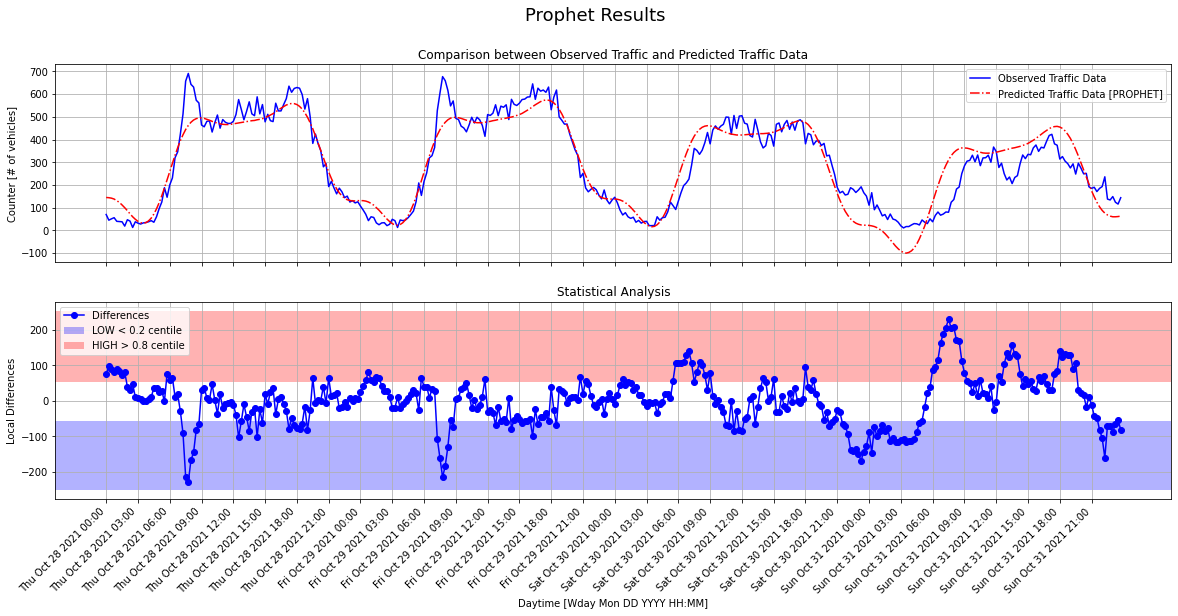

In [32]:
fig, axs = plt.subplots(2,1, figsize=(20,8), sharex=True)
ax3 = axs[0]
ax3.set_title(f'Comparison between Observed Traffic and Predicted Traffic Data')
ax3.plot(ts3, df_compared.y,'-', c='blue', label='Observed Traffic Data')
ax3.plot(ts3, df_compared.pred,'-.', c='red', label='Predicted Traffic Data [PROPHET]')
ax3.set_ylabel('Counter [# of vehicles]')
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle='--')
ax3.legend()

ax3 = axs[1]
ax3.set_title(f'Statistical Analysis')
ax3.set_xticks(ts3[::tick_us3])
ax3.set_xticklabels(ts_lbl3[::tick_us3], rotation=45, ha='right')
ax3.plot(ts3, df_compared['loc_diff'],'-o', c='blue', label='Differences')
ax3.axhspan(ax3.get_ylim()[0], thresh_down2, facecolor=kpi_colors[cg.LOW] , alpha=0.3, label=f'LOW < {kpi_thresh[cg.LOW]} centile')
ax3.axhspan(thresh_down2, thresh_up, facecolor=kpi_colors[cg.AVE] , alpha=0.3)
ax3.axhspan(thresh_up2, ax3.get_ylim()[1], facecolor=kpi_colors[cg.HIGH] , alpha=0.3, label=f'HIGH > {kpi_thresh[cg.HIGH]} centile')

ax3.grid()
ax3.legend()
ax3.set_xlabel(f'Daytime [Wday Mon DD YYYY HH:MM]')
ax3.set_ylabel('Local Differences')
plt.suptitle(f'Prophet Results', size=18 )
plt.show()

# Conclusions

In this notebook, starting from a real data set of traffic mobility fluxes  provided by Regione Emilia-Romagna, I have applied two machine learning algorithms in order to get a forcasting of the number of vehicles in the road network.

The first model that has been used is based on the Artificial Neural Network (ANN) achitecture. The population data has been divided into two sets: the first (80%) has been used for training, while the second set (20%) has been used as the test dataset.
The R-squared score in this case is very accurate and present a value of 98%.

Moreover, by fitting the data population of the observed data with the forecast prediction from the multilayer perceptron alghoritm a very good matching has been shown.

The downside of this procedure is that it takes time to be completed.

In contrast, the second model  is very efficient in term of execution time since it takes just few second to fit the data and predict a reasonable result. Unfortunately, it can predict the seasonality of the data but it loses some details in forecasting quarterly traffic data. 